# News Category Classification using RNN

##### Loading the dataset


In [33]:
import json
import numpy as np
import pandas as pd


# using pandas only to load the data, there seems to be issue with normal csv reader
train_data = pd.read_csv('datasets/train.csv')
test_data = pd.read_csv('datasets/test.csv')

# convert the data to numpy array
train_data = train_data.values
test_data = test_data.values
# first column is the label, second column is the title, third column is the description
print(train_data.shape)
print(test_data.shape)

(120000, 3)
(7600, 3)


In [34]:
train_data.view()

array([[3, 'Wall St. Bears Claw Back Into the Black (Reuters)',
        "Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."],
       [3, 'Carlyle Looks Toward Commercial Aerospace (Reuters)',
        'Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.'],
       [3, "Oil and Economy Cloud Stocks' Outlook (Reuters)",
        'Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.'],
       ...,
       [2, 'Saban not going to Dolphins yet',
        "The Miami Dolphins will put their courtship of LSU coach Nick Saban on hold to comply with the NFL's hiring policy by interviewing at least one minority candidate, a team source told The Associated Press

##### Analysing the dataset

{1, 2, 3, 4}


(array([1900.,    0.,    0., 1900.,    0.,    0., 1900.,    0.,    0.,
        1900.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

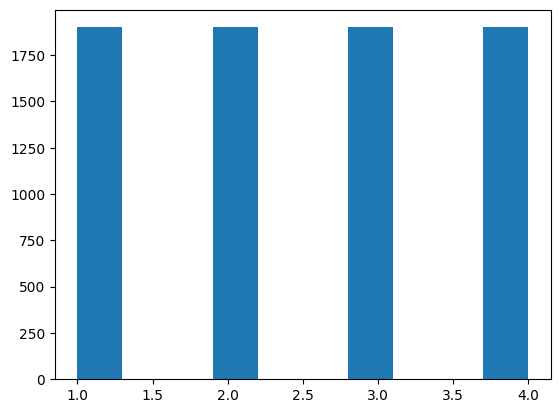

In [35]:
# view all the categories
categories = set(train_data[:, 0])
print(categories)

# 4 categories in total - "world", "sports", "business", and "Science"

# check the distribution of the categories, plot a histogram
import matplotlib.pyplot as plt
plt.hist(test_data[:, 0])

# all categories are equally distributed


In [36]:
# random seed
import random
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

random.seed(232)
np.random.shuffle(train_data)
np.random.shuffle(test_data)

def remove_special_char_and_lower_case(data):
    for record in data:
        headline = record[1]
        cleaned_headline = re.sub(r'[^a-z\s]+', '', headline.lower())
        record[1] = cleaned_headline
    return data

def stemming_and_remove_stop_words(data):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    for record in data:
        headline = record[1]
        new_headline = [stemmer.stem(word) for word in headline.split() if word not in stop_words]
        record[1] = " ".join(new_headline)
    return data

train_data = remove_special_char_and_lower_case(train_data)
test_data = remove_special_char_and_lower_case(test_data)
train_data = stemming_and_remove_stop_words(train_data)
test_data = stemming_and_remove_stop_words(test_data)


In [37]:
def unique_words(train_data, test_data):
# total unique words in the dataset
    unique_words = set()
    for record in train_data:
        headline = record[1]
        for word in headline.split():
            unique_words.add(word)
    for record in test_data:
        headline = record[1]
        for word in headline.split():
            unique_words.add(word)
    return unique_words

unique_words = unique_words(train_data, test_data)
print(len(unique_words))


# we need to pad the data to make sure all the headlines are of same length
print(' ' in unique_words)

27196
False


In [38]:
# for each record separate the words, first column is the headline, second column is the label
train_data = [[record[1].split(), record[0]] for record in train_data]
test_data = [[record[1].split(), record[0]] for record in test_data]

# find the maximum length of the headline
max_len = 0
for record in train_data:
    max_len = max(max_len, len(record[0]))
for record in test_data:
    max_len = max(max_len, len(record[0]))
print("Max Length:", max_len)

# pad the data, all headlines should be of same length, add ''
for record in train_data:
    record[0] += [''] * (max_len - len(record[0]))
for record in test_data:
    record[0] += [''] * (max_len - len(record[0]))

# add padding to the unique words
unique_words.add('')
unique_words = list(unique_words)


Max Length: 14


In [39]:
# index the words and categories. Embedding layer requires the input to be in the form of integers

vocab_size = len(unique_words)
categories = len(set(record[1] for record in train_data))
print("Number of embeddings:", vocab_size)
print("Categories:", categories)

category_to_index = {category: i for i, category in enumerate(set(record[1] for record in train_data))}
print(category_to_index)
word_to_index = {word: i for i, word in enumerate(unique_words)}
index_to_word = {i: word for i, word in enumerate(unique_words)}

train_data = [[record[0], category_to_index[record[1]]] for record in train_data]
test_data = [[record[0], category_to_index[record[1]]] for record in test_data]

MAX_LENGTH = max(len(record[0]) for record in train_data)
print("Max Length:", MAX_LENGTH)
for record in train_data:
    record[0] = [word_to_index[word] for word in record[0]]
for record in test_data:
    record[0] = [word_to_index[word] for word in record[0]]

# view the data
print(train_data[0])


Number of embeddings: 27197
Categories: 4
{1: 0, 2: 1, 3: 2, 4: 3}
Max Length: 14
[[27003, 12062, 15606, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2]


In [40]:

import torch

# INITIALIZE THE PARAMETERS
EMBEDDING_DIM = 10
embeddings = torch.randn(vocab_size, EMBEDDING_DIM)/np.sqrt(vocab_size)
HIDDEN_LAYER_DIM = 50

# rnn weights

# TODO: kaiming initialization, currently using xavier initialization
W = torch.randn(EMBEDDING_DIM, HIDDEN_LAYER_DIM)/np.sqrt(EMBEDDING_DIM)
U = torch.randn(HIDDEN_LAYER_DIM, HIDDEN_LAYER_DIM)/np.sqrt(HIDDEN_LAYER_DIM)

# feed forward network
W1 = torch.randn(HIDDEN_LAYER_DIM, HIDDEN_LAYER_DIM)/np.sqrt(HIDDEN_LAYER_DIM)
b1 = torch.randn(HIDDEN_LAYER_DIM)/np.sqrt(HIDDEN_LAYER_DIM)
W2 = torch.randn(HIDDEN_LAYER_DIM, categories)/np.sqrt(HIDDEN_LAYER_DIM)
b2 = torch.randn(categories)/np.sqrt(HIDDEN_LAYER_DIM)

# set the requires_grad to True
parameters = [W, U, W1, b1, W2, b2, embeddings]
for parameter in parameters:
    parameter.requires_grad = True



In [41]:

BATCH_SIZE = 30

for _ in range(10000):
    batch  = random.sample(train_data, BATCH_SIZE)
    X = [record[0] for record in batch]
    y = [record[1] for record in batch]
    
    h_t = torch.zeros(BATCH_SIZE, HIDDEN_LAYER_DIM)
    h_t.requires_grad = True
    for index in range(MAX_LENGTH):
        x_i = [[record[index] for record in X]]
        emb = embeddings[x_i]
        h_t = torch.tanh(emb @ W + h_t @ U)
    # layer1
    h1 = torch.tanh(h_t @ W1 + b1)
    # layer2
    logits = h1 @ W2 + b2
    # softmax    
    # to add: numerical stability ? why? - to avoid overflow of the exponential function
    logits_maxes = logits.max(1, keepdim=True).values  # keepdims=True, other wise squished to 1D, and not broadcasted
    logits_norm = logits - logits_maxes
    counts = logits_norm.exp()
    #print(counts)
    #print(counts.shape)
    counts_sum_inv = counts.sum(1, keepdim=True)
    #print(counts_sum_inv)
    y_prob = counts * counts_sum_inv**-1
    # loss (only for one record at a time, not for a batch)
    logprobs = y_prob.log()
    loss = -logprobs[range(BATCH_SIZE), y].mean()
    # backpropagation
    for parameter in parameters:
        parameter.grad = None
    
    loss.backward()

    # update the parameters
    for parameter in parameters:
        parameter.data -= 0.05 * parameter.grad
        
    print(loss.item())

1.3733693361282349
1.3817384243011475
1.387282133102417
1.4177411794662476
1.4059951305389404
1.374682068824768
1.407407522201538
1.3889070749282837
1.3884366750717163
1.3862385749816895
1.3921586275100708
1.3675028085708618
1.3930628299713135
1.381917119026184
1.3788058757781982
1.3903642892837524
1.3672293424606323
1.3844337463378906
1.4142121076583862
1.3847968578338623
1.403906226158142
1.3996423482894897
1.3761520385742188
1.371229887008667
1.3536550998687744
1.4137355089187622
1.3997939825057983
1.4205549955368042
1.3742506504058838
1.3741639852523804
1.3635375499725342
1.346732258796692
1.408254623413086
1.4320911169052124
1.3868263959884644
1.3560012578964233
1.4013625383377075
1.3725779056549072
1.356149673461914
1.3820639848709106
1.3662910461425781
1.3638676404953003
1.3691084384918213
1.3773244619369507
1.3513867855072021
1.3697144985198975
1.3071271181106567
1.3248034715652466
1.332517385482788
1.561272144317627
1.3478732109069824
1.3917478322982788
1.3838309049606323
1.36

Accuracy:  0.8335526315789473
Number of test records:  7600
Number of correct predictions:  6335


<BarContainer object of 4 artists>

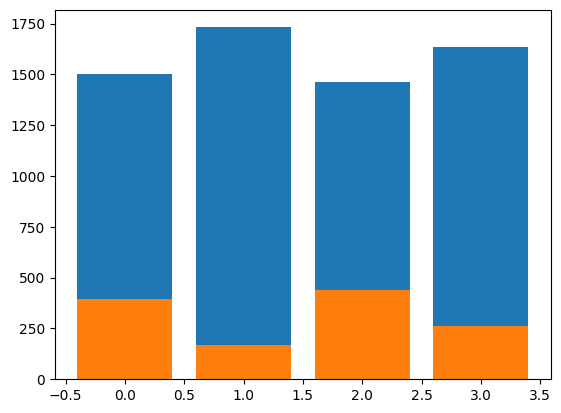

In [43]:
# test the model
# record which category the model predicts correctly and which it does not
correct = 0
total = 0
categories_correct = {}
categories_incorrect = {}
for record in test_data:
    X = record[0]
    y = record[1]
    h_t = torch.zeros(1, HIDDEN_LAYER_DIM)
    for index in range(MAX_LENGTH):
        x_i = X[index]
        emb = embeddings[x_i]
        h_t = torch.tanh(emb @ W + h_t @ U)
    h1 = torch.tanh(h_t @ W1 + b1)
    logits = h1 @ W2 + b2
    y_pred = logits.argmax().item()
    if y_pred == y:
        correct += 1
        if y not in categories_correct:
            categories_correct[y] = 0
        categories_correct[y] += 1
    else:
        if y not in categories_incorrect:
            categories_incorrect[y] = 0
        categories_incorrect[y] += 1
        #headline = " ".join(index_to_word[i] for i in X)
        #print("Headline: ", headline)
    total += 1
print("Accuracy: ", correct/total)
print("Number of test records: ", total)
print("Number of correct predictions: ", correct)


# plot categories correct and incorrect
plt.bar(categories_correct.keys(), categories_correct.values())
plt.bar(categories_incorrect.keys(), categories_incorrect.values())


### Results

- Basic RNN model, giving a baseline of 0.67 negative log likelihood. With accuracy of 83% on the test set.
    - Xavier initialization
    - Simple stochastic gradient descent
    - Batch size of 30, and embedding size of 10
    - Contains 15 time steps, and a two layer feedforward network for classification

### TODO

- Investigate where the model is failing
- Investigate the effect of the embedding size on the model performance
- Investigate the effect of the number of time steps on the model performance
- Different performance metrics


### Ideas 
- Average the word embeddings for each time step, and then pass it through the feedforward network? 
- Deepeing the network? Why or why not?


